# Explorando los datos transaccionales por formato de cilindro

En este notebook nos concentraremos en obtener insigths del comportamiento de compra de los clientes para cada tipo de cilindro. Para comenzar nos concentraremos en los siguientes formatos:
    1. CN11
    2. CN15
    3. CN02
    4. CN05
    5. CN45

In [1]:
# Importamos librerias a utilizar
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
query_gasconnect = """
SELECT A.*,
      CASE  WHEN A.n_canales = 2 THEN 'ON-OFF'
            WHEN A.n_canales = 1 AND tipo_pedido = 'ONLINE' THEN 'ONLINE'
            WHEN A.n_canales = 1 AND tipo_pedido = 'OFFLINE' THEN 'OFFLINE'
      END AS TIPO_CLIENTE,
      B.predict_estufa,
      B.predict_parrilla,
      B.predict_cocina,
      B.predict_calefont
FROM(
    SELECT  ANIO,
            MONTH,
            CAST(TELEFONO AS INT64) AS TELEFONO,
            key as FORMATO,
            --SUM(IND_TA) AS PEDIDOS_TA,
            -- SUM(KILOS_TA) AS KILOS_TA,
            COUNT(DISTINCT createdAT) AS TOTAL_PEDIDOS,
            --SUM(total_kilos_pedido) AS TOTAL_KILOS,
            MIN(EXTRACT(DATE FROM createdAt)) AS FECHA_PRIMER_PEDIDO,
            MAX(EXTRACT(DATE FROM createdAt)) AS FECHA_ULTIMO_PEDIDO,
            AVG(dias_compra) AS frec_compra_promedio, 
            stddev(dias_compra) AS desv_frec_compra,
            COUNT(DISTINCT TIPO_PEDIDO_BIEN) AS n_canales, 
            MAX(TIPO_PEDIDO_BIEN) AS tipo_pedido 
    FROM(
        SELECT extract(YEAR FROM createdAT) as ANIO, 
               extract(MONTH FROM createdat) as MONTH,
               *,
               DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono,key ORDER BY EXTRACT(DATE FROM createdat)), DAY) AS dias_compra 
        FROM(
        SELECT *, 
        FROM(
                SELECT createdAt,
                    TIPO_PEDIDO_BIEN,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45,
                    total_kilos_pedido,
                    EXTRACT(YEAR FROM createdAt) AS YEAR,
                    CASE WHEN mes in (5,6,7,8,9) THEN 1 ELSE 0 END AS IND_TA,
                    CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END AS KILOS_TA,
                    CASE WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
                            WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
                            ELSE mobile END AS Telefono,
                    CASE WHEN status = 'COMPLETED' THEN 'COMPLETADO' ELSE 'NO COMPLETADO' END AS ESTADO_PEDIDO,
                    -------------------------------------------------------------------------------------------
                FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier` 
                WHERE CAST(createdAt as DATE) >= '2020-01-01' --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
                AND isAnulled IS NULL     --PEDIDO NO ANULADO
                --AND mobile IS NOT NULL    --TELEFONO NO NULO
                AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE')
        ) AS A
        ,UNNEST(fhoffa.x.unpivot(A, 'p_CN')) unpivotted
        )
        WHERE CAST(value AS INT64) > 0
        --AND TELEFONO = '937128357'
    ) AS A
    GROUP BY ANIO,MONTH,CAST(TELEFONO AS INT64),key
) AS A

LEFT JOIN `gasco-analytics.gasco_modelos.20210218_prediccion_modelo_uso_gas` AS B  
ON(A.TELEFONO = B.telefono)
"""

**Actualización de los datos: 2021-06-04**

In [4]:
read_data = True
if read_data:
    df_anual = pd.read_csv('datos_exploratorio_fuga_formato.csv',sep = ';', index_col = 0)
else:
    query_job = client.query(query_gasconnect)  # API request
    #rows = query_job.result()  # Waits for query to finish
    df_anual = query_job.to_dataframe()

    #guardamos como csv los datos
    df_anual.to_csv('datos_exploratorio_fuga_formato.csv',sep = ';')

df_anual.head(2)

C:\Users\fbenavides\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ANIO,MONTH,TELEFONO,FORMATO,TOTAL_PEDIDOS,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,2021,3,946951677.0,p_CN15,1,2021-03-06,2021-03-06,NaN,NaN,1,ONLINE,ONLINE,NaN,NaN,NaN,NaN
1,2020,2,957904165.0,p_CN15,1,2020-02-29,2020-02-29,NaN,NaN,1,OFFLINE,OFFLINE,0.0,0.0,1.0,1.0


# Total de pedidos por formato

In [46]:
pedidos_clientes_2020 = df_anual[['ANIO','FORMATO','TOTAL_PEDIDOS','TELEFONO']]
pedidos_clientes_2020 = pedidos_clientes_2020[pedidos_clientes_2020['ANIO'] == 2020]
pedidos_clientes_2020 = pedidos_clientes_2020.groupby(['ANIO','FORMATO','TELEFONO']).sum().reset_index()

pedidos_clientes_2020.head(2)

,ANIO,FORMATO,TELEFONO,TOTAL_PEDIDOS
0,2020,p_CN02,153086680.0,1
1,2020,p_CN02,222013078.0,1


In [47]:
pedidos_clientes_2020[pedidos_clientes_2020['TELEFONO'] == 957904165]

,ANIO,FORMATO,TELEFONO,TOTAL_PEDIDOS
456775,2020,p_CN15,957904165.0,3


In [48]:
df_pedidos_sparse = pd.pivot_table(data   = df_anual,
                           index   = ['ANIO','TELEFONO'],
                           columns = 'FORMATO',
                           values  = 'TOTAL_PEDIDOS',
                           aggfunc = sum,
                           fill_value = 0)
df_pedidos_sparse.reset_index(inplace = True)

df_pedidos_sparse_2020 = df_pedidos_sparse[df_pedidos_sparse.ANIO == 2020]
df_pedidos_sparse_2020.head(2)

FORMATO,ANIO,TELEFONO,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45
0,2020,99984.0,0,1,2,5,0
1,2020,2379421.0,0,0,2,0,0


In [49]:
df_pedidos_sparse[df_pedidos_sparse['TELEFONO'] == 957904165]

FORMATO,ANIO,TELEFONO,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45
228788,2020,957904165.0,0,0,0,3,0


<AxesSubplot:xlabel='TOTAL_PEDIDOS', ylabel='FORMATO'>

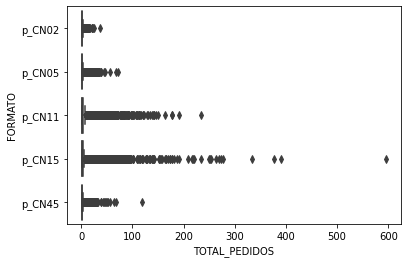

In [51]:
sns.boxplot(data = pedidos_clientes_2020, x = 'TOTAL_PEDIDOS', y = 'FORMATO')

# Revisando la cantidad de meses con compra por formato

In [52]:
df_anual.FORMATO.unique()

array(['p_CN15', 'p_CN11', 'p_CN45', 'p_CN05', 'p_CN02'], dtype=object)

In [53]:
df_formato = pd.pivot_table(data  = df_anual,
                           index = ['ANIO','TELEFONO'],
                           columns = 'FORMATO',
                           values  = 'MONTH',
                           aggfunc = 'count',
                           fill_value = 0)
df_formato.reset_index(inplace = True)

df_formato_2020 = df_formato[df_formato.ANIO == 2020]
df_formato_2020.head()

FORMATO,ANIO,TELEFONO,p_CN02,p_CN05,p_CN11,p_CN15,p_CN45
0,2020,99984.0,0,1,1,3,0
1,2020,2379421.0,0,0,2,0,0
2,2020,8911356.0,0,0,0,1,0
3,2020,9546117.0,0,0,0,1,0
4,2020,9581638.0,0,0,1,0,0


<AxesSubplot:xlabel='meses_compra', ylabel='TELEFONO'>

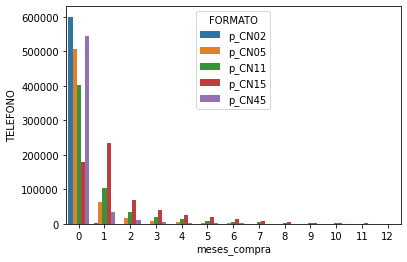

In [54]:
paso = pd.melt(df_formato_2020,
             id_vars    = 'TELEFONO',
             value_vars = ['p_CN02','p_CN05','p_CN11','p_CN15','p_CN45'],
             var_name   = 'FORMATO', 
             value_name = 'meses_compra')

clientes_mensuales = paso.groupby(['FORMATO','meses_compra']).count().reset_index()
sns.barplot(data = clientes_mensuales,
            x = 'meses_compra',
            y = 'TELEFONO',
            hue = 'FORMATO')

In [55]:
paso

,TELEFONO,FORMATO,meses_compra
0,9.998400e+04,p_CN02,0
1,2.379421e+06,p_CN02,0
2,8.911356e+06,p_CN02,0
3,9.546117e+06,p_CN02,0
4,9.581638e+06,p_CN02,0
...,...,...,...
3015730,5.690001e+14,p_CN45,0
3015731,5.690001e+14,p_CN45,0
3015732,5.690001e+14,p_CN45,0
3015733,5.641000e+15,p_CN45,0


<AxesSubplot:xlabel='meses_compra', ylabel='TELEFONO'>

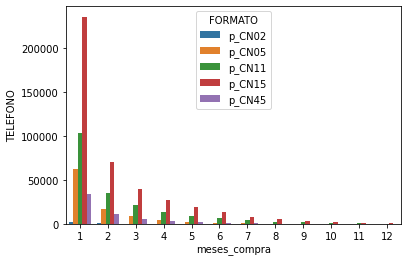

In [57]:
sns.barplot(data = clientes_mensuales[~clientes_mensuales.meses_compra.isin([0])],
            x    = 'meses_compra',
            y    = 'TELEFONO',
            hue  = 'FORMATO')

In [62]:
a = clientes_mensuales[~clientes_mensuales.meses_compra.isin([0])]
a[a.FORMATO == 'p_CN11']

<AxesSubplot:xlabel='meses_compra', ylabel='Proportion'>

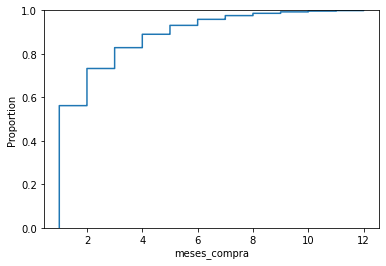

In [63]:
sns.ecdfplot(data = paso[~paso.meses_compra.isin([0])],
             x    = 'meses_compra')

# Otros analisis

In [64]:
df_CN02 = df_anual[df_anual['FORMATO'] == 'p_CN02']
df_CN05 = df_anual[df_anual['FORMATO'] == 'p_CN05']
df_CN11 = df_anual[df_anual['FORMATO'] == 'p_CN11']
df_CN15 = df_anual[df_anual['FORMATO'] == 'p_CN15']

df_CN02_pivot = pd.pivot_table(data = df_CN02,
                               index = 'TELEFONO',
                               columns = 'MONTH',
                               values = 'TOTAL_PEDIDOS',
                               aggfunc = [any,np.sum],
                               fill_value = 0)*1

df_CN05_pivot = pd.pivot_table(data = df_CN05,
                               index = 'TELEFONO',
                               columns = 'MONTH',
                               values = 'TOTAL_PEDIDOS',
                               aggfunc = [any,np.sum],
                               fill_value = 0)*1

df_CN11_pivot = pd.pivot_table(data = df_CN11,
                               index = 'TELEFONO',
                               columns = 'MONTH',
                               values = 'TOTAL_PEDIDOS',
                               aggfunc = [any,np.sum],
                               fill_value = 0)*1 

df_CN15_pivot = pd.pivot_table(data = df_CN15,
                               index = 'TELEFONO',
                               columns = 'MONTH',
                               values = 'TOTAL_PEDIDOS',
                               aggfunc = [any,np.sum],
                               fill_value = 0)*1 

In [65]:
df_CN02_pivot['meses_compra']  = df_CN02_pivot['any'].sum(axis = 1)
df_CN02_pivot['total_pedidos'] = df_CN02_pivot['sum'].sum(axis = 1)

df_CN05_pivot['meses_compra']  = df_CN05_pivot['any'].sum(axis = 1)
df_CN05_pivot['total_pedidos'] = df_CN05_pivot['sum'].sum(axis = 1)

df_CN11_pivot['meses_compra']  = df_CN11_pivot['any'].sum(axis = 1)
df_CN11_pivot['total_pedidos'] = df_CN11_pivot['sum'].sum(axis = 1)

df_CN15_pivot['meses_compra']  = df_CN15_pivot['any'].sum(axis = 1)
df_CN15_pivot['total_pedidos'] = df_CN15_pivot['sum'].sum(axis = 1)

In [66]:
conteo_02 = df_CN02_pivot.groupby('meses_compra').count().reset_index()
conteo_05 = df_CN05_pivot.groupby('meses_compra').count().reset_index()
conteo_11 = df_CN11_pivot.groupby('meses_compra').count().reset_index()
conteo_15 = df_CN15_pivot.groupby('meses_compra').count().reset_index()

# Test analisis con CN45

In [67]:
df_CN45 = df_anual[df_anual['FORMATO'] == 'p_CN45']

df_CN45_pivot = pd.pivot_table(data = df_CN45,
                               index = 'TELEFONO',
                               columns = 'MONTH',
                               values = 'TOTAL_PEDIDOS',
                               aggfunc = [any, np.sum],
                               fill_value = 0)*1

#df_CN45_pivot.reset_index()
df_CN45_pivot.head()

any                             ... sum                           
MONTH       1  2  3  4  5  6  7  8  9  10  ...  3  4  5  6  7  8  9  10 11 12
TELEFONO                                   ...                               
22225307.0   0  0  0  0  0  0  0  1  0  0  ...   0  0  0  0  0  1  0  0  0  0
22241929.0   0  0  0  0  0  0  1  0  0  0  ...   0  0  0  0  1  0  0  0  0  0
22296159.0   0  0  0  0  0  1  0  0  0  0  ...   0  0  0  1  0  0  0  0  0  0
22325813.0   0  0  0  0  0  0  0  0  0  0  ...   0  0  0  0  0  0  0  0  1  0
23259550.0   0  0  0  0  1  0  0  0  1  0  ...   0  0  1  0  0  0  1  0  0  0

[5 rows x 24 columns]

In [68]:
df_CN45_pivot['meses_compra'] = df_CN45_pivot['any'].sum(axis = 1)
df_CN45_pivot['total_pedidos'] = df_CN45_pivot['sum'].sum(axis = 1)

In [69]:
a = df_CN15_pivot[['meses_compra']].reset_index()
b = df_CN05_pivot[['meses_compra']].reset_index()

print(a.size, b.size)

#a.merge(b,
#        how = 'outer',
#        on  = 'meses_compra')

1067206 242390


In [70]:
df_meses_compra =  df_CN15_pivot[['meses_compra']].reset_index().merge(df_CN05_pivot[['meses_compra']].reset_index(),
                                                                       how = 'outer',
                                                                       on  = 'meses_compra')


#df_CN05_pivot[['meses_compra']].reset_index()
#df_CN11_pivot[['meses_compra']].reset_index()
#df_CN45_pivot[['meses_compra']].reset_index()

C:\Users\fbenavides\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


MemoryError: Unable to allocate 188. GiB for an array with shape (25211449973,) and data type int64

In [ ]:
pd.merge

In [ ]:
meses_con_pedidos = pd.concat([conteo_05.meses_compra,
                               conteo_05.total_pedidos,conteo_11.total_pedidos,
                               conteo_15.total_pedidos,conteo_45.total_pedidos], axis = 1)
meses_con_pedidos.columns = ['mes','CN05','CN11','CN15','CN45']
#meses_con_pedidos.head()

meses_con_pedidos_v2 = pd.melt(meses_con_pedidos,
                               id_vars    = 'mes',
                               value_vars = ['CN05','CN11','CN15','CN45'],
                               var_name   = 'formato',
                               value_name = 'cant_clientes')

In [ ]:
sns.barplot(data = meses_con_pedidos_v2, x = 'mes', y =  'cant_clientes', hue = 'formato')